In [1]:
import numpy as np
import torch
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim

Dummy Data

In [17]:
# Generate quadratic data for x and calculate corresponding y
B, T, D = 14, 20770, 64
x = np.linspace(-1, 1, T)
dummy_data = np.zeros((B, T, D), dtype=np.float32)
dummy_labels = np.zeros((B, T, 2), dtype=np.float32)

for batchb in range(B):
    # Quadratic function: y = ax^2 + bx + c
    a, b, c = np.random.rand(3)
    y = a * x**2 + b * x + c
    dummy_data[batchb, :, 0] = x
    dummy_data[batchb, :, 1] = y
    dummy_labels[batchb, :, 0] = 2 * a * x + b  # Derivative of y with respect to x
    dummy_labels[batchb, :, 1] = 1  # Placeholder for the second dimension

# Reshape the dummy data and labels to match the (B, T, D) and (B, T, 2) formats
dummy_data_tensor = torch.from_numpy(dummy_data)
dummy_labels_tensor = torch.from_numpy(dummy_labels)

# Split the data into training and testing sets
train_size = int(0.8 * B)
train_data, test_data = dummy_data_tensor[:train_size], dummy_data_tensor[train_size:]
train_labels, test_labels = dummy_labels_tensor[:train_size], dummy_labels_tensor[train_size:]

In [18]:
print(train_data.shape)
print(train_labels.shape)

torch.Size([11, 10000, 64])
torch.Size([11, 10000, 2])


In [3]:
# Create TensorDatasets for training and testing sets
train_dataset = TensorDataset(train_data, train_labels)
test_dataset = TensorDataset(test_data, test_labels)

In [4]:
# Set the batch size
batch_size = 128

# Create DataLoader for training and testing sets
#train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
inference_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

In [5]:
train_i = 0
for i, (batch_data, batch_labels) in enumerate(train_loader):
    print(f"Batch {i + 1} - Data Shape: {batch_data.shape}, Labels Shape: {batch_labels.shape}")
    train_i += 1
print(train_i)

print()

test_i = 0
for i, (batch_data, batch_labels) in enumerate(test_loader):
    print(f"Batch {i + 1} - Data Shape: {batch_data.shape}, Labels Shape: {batch_labels.shape}")
    test_i += 1
print(test_i)

print()

inf_i = 0
for i, (batch_data, batch_labels) in enumerate(inference_loader):
    print(f"Batch {i + 1} - Data Shape: {batch_data.shape}, Labels Shape: {batch_labels.shape}")
    inf_i += 1
print(inf_i)

Batch 1 - Data Shape: torch.Size([11, 10000, 64]), Labels Shape: torch.Size([11, 10000, 2])
1

Batch 1 - Data Shape: torch.Size([3, 10000, 64]), Labels Shape: torch.Size([3, 10000, 2])
1

Batch 1 - Data Shape: torch.Size([1, 10000, 64]), Labels Shape: torch.Size([1, 10000, 2])
Batch 2 - Data Shape: torch.Size([1, 10000, 64]), Labels Shape: torch.Size([1, 10000, 2])
Batch 3 - Data Shape: torch.Size([1, 10000, 64]), Labels Shape: torch.Size([1, 10000, 2])
3


In [6]:
# Initialize the model
input_size = D  # Number of features in the input data
output_size = 2  # Number of dimensions in the output labels

## Linear Regression

Epoch [1/100], Loss: 0.9830
Epoch [11/100], Loss: 0.7840
Epoch [21/100], Loss: 0.6350
Epoch [31/100], Loss: 0.5233
Epoch [41/100], Loss: 0.4392
Epoch [51/100], Loss: 0.3756
Epoch [61/100], Loss: 0.3272
Epoch [71/100], Loss: 0.2902
Epoch [81/100], Loss: 0.2616
Epoch [91/100], Loss: 0.2394


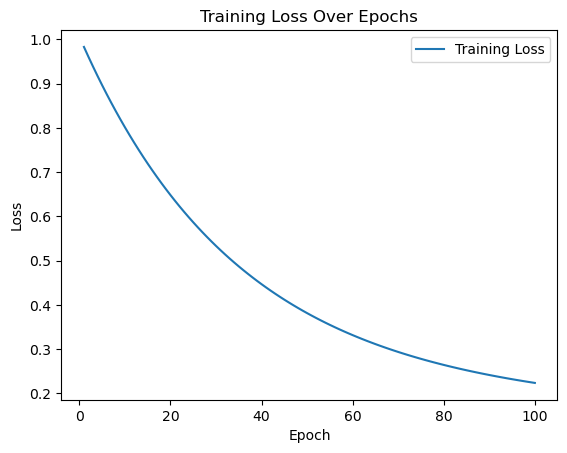

In [7]:
# Define a simple linear regression model
class LinearRegressionModel(nn.Module):
    def __init__(self, input_size, output_size):
        super(LinearRegressionModel, self).__init__()
        self.linear = nn.Linear(input_size, output_size)

    def forward(self, x):
        return self.linear(x)

model = LinearRegressionModel(input_size, output_size)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

# Training loop
num_epochs = 100
train_loss_log = []
for epoch in range(num_epochs):
    for batch_data, batch_labels in train_loader:
        # Flatten the input data
        batch_data = batch_data.view(-1, input_size)

        # Forward pass
        outputs = model(batch_data)
        loss = criterion(outputs, batch_labels.view(-1, output_size))
        train_loss_log.append(loss.item())

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    if epoch%10==0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# Plot the training loss over epochs
plt.plot(range(1, num_epochs+1), train_loss_log, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.show()

In [8]:
# Testing loop
model.eval()
with torch.no_grad():
    total_loss = 0
    for batch_data, batch_labels in test_loader:
        print(batch_data.shape)
        batch_data = batch_data.view(-1, input_size)
        print(batch_data.shape)
        outputs = model(batch_data)
        print(outputs.shape)
        total_loss += criterion(outputs, batch_labels.view(-1, output_size)).item()
        print()

    average_loss = total_loss / len(test_loader)
    print(f'Test Loss: {average_loss:.4f}')

torch.Size([3, 10000, 64])
torch.Size([30000, 64])
torch.Size([30000, 2])

Test Loss: 0.0906


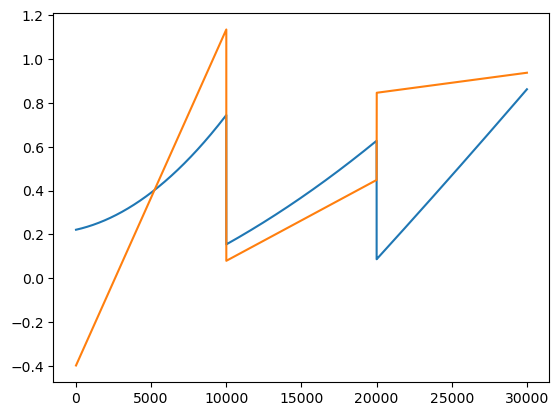

In [9]:
plt.plot(outputs[:,0])
plt.plot(batch_labels.view(-1, output_size)[:,0])

Single at a time

In [10]:
# Testing loop
model.eval()
outputs_log = []
labels_log = []
with torch.no_grad():
    total_loss = 0
    for batch_data, batch_labels in test_loader:
        print(f"batch_data.shape: {batch_data.shape}")
        for user_num in range(batch_data.shape[0]):
            user1_seq_data = batch_data[user_num,:,:]
            user1_seq_labels = batch_labels[user_num,:,:]
            print(f"user1_seq_data.shape: {user1_seq_data.shape}")
            iter_i = 0
            for (one_seq, one_seq_label) in zip(user1_seq_data, user1_seq_labels):
                iter_i += 1
                outputs = model(one_seq)
                outputs_log.append(outputs[0].item())
                labels_log.append(one_seq_label[0].item())
                if iter_i%1000==0:
                    #print(f"outputs.shape: {outputs.shape}")
                    print(f"{outputs}, {one_seq_label}")
                total_loss += criterion(outputs, one_seq_label).item()
            print()

    average_loss = total_loss / len(test_loader)
    print(f'Test Loss: {average_loss:.4f}')

batch_data.shape: torch.Size([3, 10000, 64])
user1_seq_data.shape: torch.Size([10000, 64])
tensor([0.2401, 0.6604]), tensor([-0.2450,  1.0000])
tensor([0.2666, 0.6649]), tensor([-0.0917,  1.0000])
tensor([0.3004, 0.6766]), tensor([0.0616, 1.0000])
tensor([0.3416, 0.6955]), tensor([0.2148, 1.0000])
tensor([0.3903, 0.7216]), tensor([0.3681, 1.0000])
tensor([0.4463, 0.7549]), tensor([0.5214, 1.0000])
tensor([0.5096, 0.7954]), tensor([0.6746, 1.0000])
tensor([0.5804, 0.8431]), tensor([0.8279, 1.0000])
tensor([0.6586, 0.8980]), tensor([0.9812, 1.0000])
tensor([0.7442, 0.9601]), tensor([1.1344, 1.0000])

user1_seq_data.shape: torch.Size([10000, 64])
tensor([0.1935, 0.6149]), tensor([0.1162, 1.0000])
tensor([0.2345, 0.6336]), tensor([0.1531, 1.0000])
tensor([0.2774, 0.6541]), tensor([0.1899, 1.0000])
tensor([0.3220, 0.6763]), tensor([0.2268, 1.0000])
tensor([0.3684, 0.7002]), tensor([0.2637, 1.0000])
tensor([0.4165, 0.7259]), tensor([0.3006, 1.0000])
tensor([0.4665, 0.7533]), tensor([0.3374, 

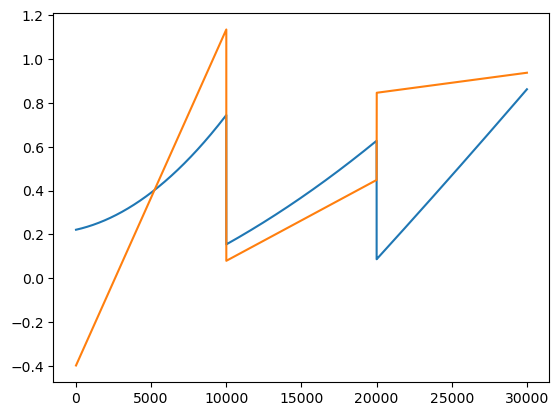

In [11]:
plt.plot(outputs_log)
plt.plot(labels_log)

> Above, I show that you get the same outputs when you use the same model, whether or not you compute all the data at once (eg the default) or doing it one by one

## RNN

In [13]:
#input_size = D  # Number of features in the input data
#output_size = 2  # Number of dimensions in the output labels
hidden_size = 64

Batch 0. batch_data size: torch.Size([11, 10000, 64]). batch_labels size: torch.Size([11, 10000, 2]). rnn_outputs size: torch.Size([11, 10000, 2]).
RNN Epoch [1/100], Loss: 0.8915
RNN Epoch [11/100], Loss: 0.5296
RNN Epoch [21/100], Loss: 0.3125
RNN Epoch [31/100], Loss: 0.2041
RNN Epoch [41/100], Loss: 0.1645
RNN Epoch [51/100], Loss: 0.1497
RNN Epoch [61/100], Loss: 0.1405
RNN Epoch [71/100], Loss: 0.1324
RNN Epoch [81/100], Loss: 0.1249
RNN Epoch [91/100], Loss: 0.1179


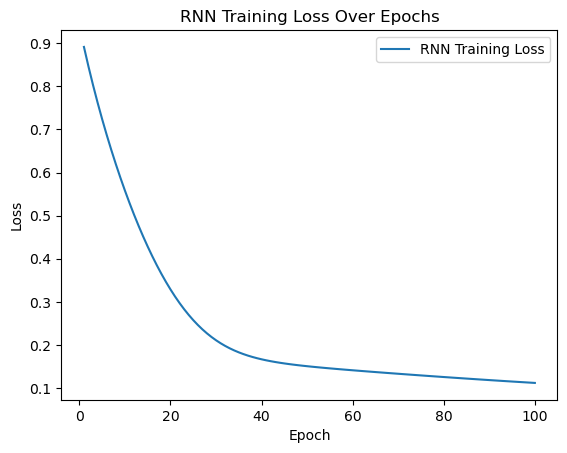

In [14]:
# Define a simple RNN model
class RNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNNModel, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # RNN input: (batch_size, seq_len, input_size)
        # Output: (batch_size, seq_len, hidden_size)
        rnn_out, _ = self.rnn(x)

        # Fully connected layer
        output = self.fc(rnn_out)
        return output

# Initialize the RNN model
rnn_model = RNNModel(D, hidden_size, 2)  # Change output_size to 2

# Define loss function and optimizer for the RNN model
rnn_criterion = nn.MSELoss()
rnn_optimizer = optim.SGD(rnn_model.parameters(), lr=0.01)

# Training loop for the RNN model
rnn_train_losses = []

num_epochs = 100
for epoch in range(num_epochs):
    rnn_epoch_losses = []
    batch_counter = 0
    for batch_data, batch_labels in train_loader:
        #print(f"Pre-reshape batch_data size: {batch_data.shape}")
        # Reshape the input data to (batch_size, seq_len, input_size)
        #batch_data = batch_data.permute(0, 2, 1)
        #print(f"Post-reshape batch_data size: {batch_data.shape}")

        # Make sure the input size matches the RNN input size
        assert batch_data.size(-1) == D, f"Expected input size {D}, got {batch_data.size(-1)}"

        # Forward pass
        rnn_outputs = rnn_model(batch_data)

        if epoch==0:
            print(f"Batch {batch_counter}. batch_data size: {batch_data.shape}. batch_labels size: {batch_labels.shape}. rnn_outputs size: {rnn_outputs.shape}.")
        batch_counter += 1
        
        rnn_loss = rnn_criterion(rnn_outputs, batch_labels)

        # Backward and optimize
        rnn_optimizer.zero_grad()
        rnn_loss.backward()
        rnn_optimizer.step()

        rnn_epoch_losses.append(rnn_loss.item())

    average_rnn_epoch_loss = sum(rnn_epoch_losses) / len(rnn_epoch_losses)
    rnn_train_losses.append(average_rnn_epoch_loss)
    if epoch%10==0:
        print(f'RNN Epoch [{epoch+1}/{num_epochs}], Loss: {average_rnn_epoch_loss:.4f}')

# Plot the training loss for the RNN model over epochs
plt.plot(range(1, num_epochs+1), rnn_train_losses, label='RNN Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('RNN Training Loss Over Epochs')
plt.legend()
plt.show()


In [19]:
print("TRAIN LOADER")
model.eval()
with torch.no_grad():
    dim0 = 0
    dim1 = 0
    dim2 = 0
    batch_counter = 0
    for batch_data, batch_labels in train_loader:
        print(batch_counter)
        batch_counter += 1
        print(f"Pre-reshape batch_data size: {batch_data.shape}")
        print(f"Pre-reshape batch_labels size: {batch_labels.shape}")
        dim0 += batch_data.shape[0]
        dim1 += batch_data.shape[1]
        dim2 += batch_data.shape[2]
        
        print()
    print(f"Summed dims: ({dim0}, {dim1}, {dim2})")

TRAIN LOADER
0
Pre-reshape batch_data size: torch.Size([11, 10000, 64])
Pre-reshape batch_labels size: torch.Size([11, 10000, 2])

Summed dims: (11, 10000, 64)


In [20]:
print("TEST LOADER")
model.eval()
with torch.no_grad():
    dim0 = 0
    dim1 = 0
    dim2 = 0
    for batch_data, batch_labels in test_loader:
        print(f"Pre-reshape batch_data size: {batch_data.shape}")
        print(f"Pre-reshape batch_labels size: {batch_labels.shape}")
        dim0 += batch_data.shape[0]
        dim1 += batch_data.shape[1]
        dim2 += batch_data.shape[2]
        
        print()
    print(f"Summed dims: ({dim0}, {dim1}, {dim2})")

TEST LOADER
Pre-reshape batch_data size: torch.Size([3, 10000, 64])
Pre-reshape batch_labels size: torch.Size([3, 10000, 2])

Summed dims: (3, 10000, 64)


In [23]:
# Testing loop
model.eval()
with torch.no_grad():
    total_loss = 0
    for batch_data, batch_labels in test_loader:
        print(f"batch_data size: {batch_data.shape}")
        print(f"batch_labels size: {batch_labels.shape}")
        outputs = rnn_model(batch_data)
        #reshaped_batch_labels = batch_labels.view(-1, output_size)
        print(f"outputs size: {outputs.shape}")
        #print(f"reshaped_batch_labels size: {reshaped_batch_labels.shape}")
        total_loss += criterion(outputs, batch_labels).item()

    average_loss = total_loss / len(test_loader)
    print(f'Test Loss: {average_loss:.4f}')

batch_data size: torch.Size([3, 10000, 64])
batch_labels size: torch.Size([3, 10000, 2])
outputs size: torch.Size([3, 10000, 2])
Test Loss: 0.0618


## LSTM

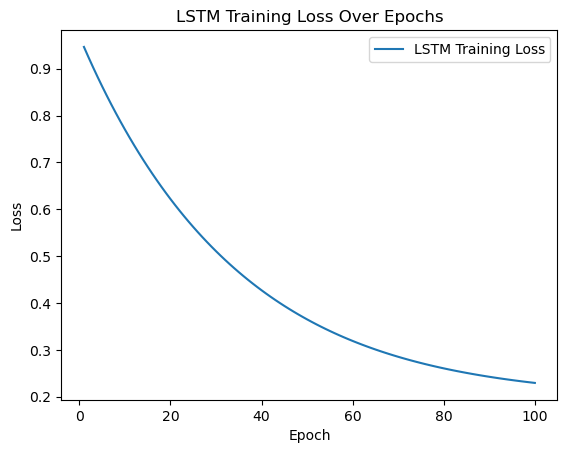

In [24]:
# Define a simple LSTM model
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # LSTM input: (batch_size, seq_len, input_size)
        # Output: (batch_size, seq_len, hidden_size)
        lstm_out, _ = self.lstm(x)

        # Take the last time step's output
        last_output = lstm_out#[:, , :]

        # Fully connected layer
        output = self.fc(last_output)
        return output

# Initialize the LSTM model
hidden_size = 64
lstm_model = LSTMModel(D, hidden_size, output_size)  # Change input_size to D

# Define loss function and optimizer for the LSTM model
lstm_criterion = nn.MSELoss()
lstm_optimizer = optim.SGD(lstm_model.parameters(), lr=0.01)

# Training loop for the LSTM model
lstm_train_losses = []

num_epochs = 100
for epoch in range(num_epochs):
    lstm_epoch_losses = []
    for batch_data, batch_labels in train_loader:
        # Reshape the input data to (batch_size, seq_len, input_size)
        #batch_data = batch_data.view(batch_data.size(0), -1, D)

        # Make sure the input size matches the LSTM input size
        assert batch_data.size(-1) == D, f"Expected input size {D}, got {batch_data.size(-1)}"

        # Forward pass
        lstm_outputs = lstm_model(batch_data)
        lstm_loss = lstm_criterion(lstm_outputs, batch_labels)

        # Backward and optimize
        lstm_optimizer.zero_grad()
        lstm_loss.backward()
        lstm_optimizer.step()

        lstm_epoch_losses.append(lstm_loss.item())

    average_lstm_epoch_loss = sum(lstm_epoch_losses) / len(lstm_epoch_losses)
    lstm_train_losses.append(average_lstm_epoch_loss)
    if epoch%10==0:
        (f'LSTM Epoch [{epoch+1}/{num_epochs}], Loss: {average_lstm_epoch_loss:.4f}')

# Plot the training loss for the LSTM model over epochs
plt.plot(range(1, num_epochs+1), lstm_train_losses, label='LSTM Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('LSTM Training Loss Over Epochs')
plt.legend()
plt.show()

In [25]:
# Testing loop
model.eval()
with torch.no_grad():
    total_loss = 0
    for batch_data, batch_labels in test_loader:
        batch_data = batch_data.view(-1, input_size)
        outputs = model(batch_data)
        total_loss += criterion(outputs, batch_labels.view(-1, output_size)).item()

    average_loss = total_loss / len(test_loader)
    print(f'Test Loss: {average_loss:.4f}')

Test Loss: 0.0906
